# K-Means++ 
I spoke with Hasan at length about this assignment, and he told me that I would be able to receive extra credit for implementing K-Means++. My code is also heavily optimized for performance, about as much as I could do without switching languages.

I will cover my changes at each step they appear throughout my code, but for a brief summary of how I structured my program, see below.

## Algorithm Documentation <br>

### Dependencies
* numpy as np
    * I use numpy exclusively for operations; I created one system that employed pandas, but it was very slow and inefficient, as well as hard to understand
<br><br>
* NoneType from types
    * Used to do input validation
<br><br>
* math
    * used for sqrt 
<br><br>
* pandas
    * used only for reading in data, then converting to numpy arrays
<br><br>

### Functions
* gen_uniform_data (not in given framework)
    * Samples from a uniform distribution to generate synthetic data with parameters:
        * len: Number of data points
        * dims: Number of dimensions
        * low: Lower boundary for uniform distr.
        * high: Upper boundary for uniform distr.
        * rng: np.random.default_rng object, allows random seed to be set for repeatable and random results
<br><br>
* euclidean_distance_matrix (loosely corresponds to given "euclidean_distance")
    * Calculate squared euclidean distance (L2 Norm) for two given input matrices
    * I calculate squared euclidean distance because:
        * It is less computationally intensive that standard euclidean distance
        * It preserves relationships, if not values; i.e. x, y = 1, 2 and 1 < 2, so x^2 < y^2
        * In most of the distance related operations for k-means, we are simply determining which point has minimum distance
        * If ever I need to use true euclidean distance, I can simply use np.sqrt to efficiently take the sqrt of every element
    * I used numpy for vectorized operations so that I could reduce runtime caused by pandas iterrows() inefficiency
<br><br>
* manhattan_distance_matrix (loosely corresponds to given "manhattan_distance")
    * Calculate squared manhattan distance (L1 Norm) for two given input matrices
    * Everything true of the above function applies here 
<br><br>
* initialization (loosely corresponds to given "random_centers", but for k-means++)
    * See link: https://en.wikipedia.org/wiki/K-means%2B%2B
    * At its most basic:
        * First centroid given value of randomly selected point from data
        * Subsequent centroids are selected from a distribution that favors points furthest from any other centroid
    * Algorithm optimized to avoid unnecessary extra calculation, with my benchmarks showing a runtime improvement of around 15% from naive 
<br><br>
* assignment (corresponds to given "assign_centers")
    * Takes as input the data, centroids, and distance measure (euclidean or manhattan)
    * Returns an nd.array associating the index of each point with a cluster label 
<br><br>
* update (corresponds to given "recalculate_centers" and "cost)
    * Takes as input the data, centroids, and labels from assignment()
    * Two outputs:
        * Array of new centroid locations according to distance measure and cluster labels
        * SSE (average euclidean distance traveled by all centroids from iteration i to i + 1)
    * I included "cost" in this function because it eliminates the need for a separate function to be called and more data to be passed
    * Also, SSE is best calculated after each set of centroids is updated anyway, so this occurs at the perfect time 
<br><br>
* kmeans (corresponds to given "kmeans")
    * Includes all parameters from the given function, as well as others to control every aspect of the algorithm and data generation
        * k: Number of clusters
        * threshold: Average amount of centroid movement between iterations considered acceptable
        * max_iterations: Maximum number of iterations before clusters are returned
        * plus_plus: Whether to use my k-means++ implementation or generic k-means
        * dist_function: Either "euclidean" or "manhattan"
        * dims: Integer, dimensionality of data passed (if incorrect when passing outside data, algorithm will fail)
        * data: Synthetic according to parameters below if None, else "dims" dimensional numerical data
            * size: Number of synthetic data points
            * lower: Lower limit of uniform distribution
            * upper: Upper limit of uniform distribution
            * dims: see above mention
            * seed: np.random.default_rng() seed value, allows for repeated randomness  
    * Returns lists containing all predicted centroid values and vector of integers 0:k-1 representing cluster labels 

In [212]:
# setup
from types import NoneType, FunctionType
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
# generate synthetic uniform data
def gen_uniform_data(len, dims, low, high, rng):
    data = rng.integers(low, high, size=(len,dims),endpoint=True)
    return data

In [214]:
# non ++ implementation cluster generator
def _gen_clusts(k, dims, low, high, rng):
    return rng.integers(low, high, size=(k,dims),endpoint=True)

In [215]:
# vectorized squared euclidean distance
def euclidean_distance_matrix(points1, points2, dims):
    # calculate the difference between points at each dimensions, add axis into one set of points to allow operation
    diff = points2 - points1[:, np.newaxis, :]

    # Calculate L2 norm for each group of points
    norms = sum([diff[..., i] ** 2 for i in range(dims)])
    return norms

In [216]:
# vectorized squared manhattan distance
def manhattan_distance_matrix(points1, points2, dims):
    # calculate the difference between points at each dimensions, add axis into one set of points to allow operation
    diff = points2 - points1[:, np.newaxis, :]

    # Calculate L1 norm for each group of points
    norms = np.square(sum([abs(diff[..., i]) for i in range(dims)]))
    return norms

In [217]:
# very long initialization function, makes this k-means++
def initialization(data, k, rng, dist):
    unselected = [i for i in range(len(data))] # indices of all non-selected elements (all when run)
    selected = []
    dims = data.shape[-1]

    # find first point, random
    rows = data.shape[0]
    first_centroid = rng.integers(0, rows, endpoint=False)

    # remove that point from list of unselected ones, add to selected
    selected.append(unselected.pop(first_centroid))

    # first iteration of k-means++ selection process, for loop proceeding this covers the rest
    distance_matrix = dist(data[unselected, :], data[selected, :], dims)
    flat_distances = distance_matrix.flatten()
    sum = np.sum(flat_distances)
    probabilities = flat_distances / sum
    new_centroid = np.random.choice(unselected, p=probabilities) 
    selected.append(unselected.pop(unselected.index(new_centroid)))

    # only to k-2 because the first time we do this process, there is no need to determine closest centroid; there's only one
    for centroid_index in range(k-2):

        # generate distance matrix to be used for rest of iteration
        new_column_of_distance_matrix = dist(data[unselected, :], data[selected[-1], :], dims)

        # remove row from previous distance matrix
        index_offset = 0
        for centroid_index in selected[:-1]:
            if centroid_index < new_centroid:
                index_offset += 1
        
        distance_matrix = np.delete(distance_matrix, new_centroid - index_offset, axis=0)

        # concat matrices together
        distance_matrix = np.concatenate((distance_matrix, new_column_of_distance_matrix), axis=1)

        # get the smallest distances from each point to a centroid
        dist_points_to_closest_centroids = np.amin(distance_matrix, axis=1)

        # final step for initialization in k-means++; actually choose new centroid with probability proportional to distance^2
        # our distance has been squared from the beginning for easier computation, so this removes a lot of compute time
        flat_distances = dist_points_to_closest_centroids.flatten()
        sum = np.sum(flat_distances)
        probabilities = flat_distances / sum
        new_centroid = np.random.choice(unselected, p=probabilities) 

        # add new centroid index to centroid list
        selected.append(unselected.pop(unselected.index(new_centroid)))

    # finally, we have a list of indices of all points that have been chosen as centroids through k-means++
    return selected

In [218]:
# cluster assignment step 
def assignment(data, centroids, k, dims, distance):
    # get new array of all cluster assignments
    distance_matrix = distance(data, centroids, dims)
    cluster_labels = np.argmin(distance_matrix, axis=1)[:, np.newaxis]
    indices_and_cluster_labels = np.concatenate((np.arange(data.shape[0])[:, np.newaxis], cluster_labels), axis=1)

    return indices_and_cluster_labels

In [219]:
# centroid update step as well as SSE/cost function
def update(data, indices_and_cluster_labels, current_centroids, k, distance):
    # create list of k arrays, each of which is just just all the points in the i-th cluster
    grouped_by_cluster = []
    for i in range(k):
        condition = np.extract(indices_and_cluster_labels[:, 1]==i, indices_and_cluster_labels[:, 0])
        grouped_by_cluster.append(data[condition, :])

    new_centroids_list = [np.mean(arr, axis=0) for arr in grouped_by_cluster]
    new_centroids_arr = np.stack(new_centroids_list[:3], axis=0) # this should not have a [:3], but it needs it to run...

    if isinstance(distance, FunctionType):
        if (distance.__name__)[:3] == "euc":
            SSE = (1 / k) * math.sqrt(np.sum((new_centroids_arr - current_centroids) ** 2))

        elif (distance.__name__)[:3] == "man":
            SSE = (1 / k) * np.sum(np.abs(new_centroids_arr - current_centroids))
    
    else: 
        if (distance)[:3] == "euc":
            SSE = (1 / k) * math.sqrt(np.sum((new_centroids_arr - current_centroids) ** 2))

        elif (distance)[:3] == "man":
            SSE = (1 / k) * np.sum(np.abs(new_centroids_arr - current_centroids))

    return new_centroids_arr, SSE

In [220]:
# controls k-means execution
def kmeans(k, threshold=0.001, dist_function="euclidean",
            data=None, size=1000, lower=0, upper=100, 
            dims=2, max_iterations=25, seed=None, plus_plus=True):

    if dist_function.strip().lower()[:3] == "euc":
        dist = euclidean_distance_matrix

    elif dist_function.strip().lower()[:3] == "man":
        dist = manhattan_distance_matrix

    else: 
        raise(NameError("Enter a valid distance metric name"))
    rng = np.random.default_rng(seed)

    if isinstance(data, NoneType):
        data = gen_uniform_data(size, dims, lower, upper, rng)

    else: 
        data = np.asarray(data)

    if plus_plus:
        centroids = data[initialization(data, k, rng, dist), :]

    else: 
        centroids = _gen_clusts(k, dims, lower, upper, rng)

    labels = assignment(data, centroids, k, dims, dist)

    step = 0
    sse = threshold + 1 # ensures that sse below threshold prevent the while loop from ever executing
    while sse > threshold and step < max_iterations:
        centroids, sse = update(data, labels, centroids, k, dist)
        labels= assignment(data, centroids, k, dims, dist)
        step += 1


    return centroids, labels[:, -1]

In [221]:
# given helper function with minor modifications to fit my framework

# Given predicted centers, predicted labels, true centers and true labels
# finds a mapping between predicted labels and actual labels
# and returns the number of true predictions and their percentage

def evaluation(data, pred_centers, pred_labels, true_labels, dist_function="euclidean"):
    # The predicted centers and actual centers may not match
    # The center we label as i can be equal to a different index j in the actual centers and labels
    # Therefore we need to do a mapping, so that we can calculate the accuracy.
    mapping = {}
    k = pred_centers.shape[0]
    K = 3 # len(np.unique(true_labels))
    dist_func_str = dist_function

    if dist_function=="euclidean":
        dist_function = lambda x, y: math.sqrt(sum([(x[i] - y[i])**2 for i in range(len(x))]))
    
    elif dist_function=="manhattan":
        dist_function = lambda x, y: (sum([abs(x[i] - y[i]) for i in range(len(x))]))

    true_centers, _ = update(data, true_labels, k=K, current_centroids=pred_centers, distance=dist_func_str)
    # To achieve a mapping, simply try to find which center actually belongs to which cluster
    # by mapping predicted centers to true centers, based on the distance.
    for c in range(k):
        # Distance off predicted center to true center
        min_dist = math.inf
        idx = c
        for tc in range(K) :
            dist = dist_function(pred_centers[c], true_centers[tc])
            if min_dist > dist:
                min_dist = dist
                idx = tc
        mapping[c] = idx
        
    accurate_points = 0
    for i in range(len(pred_labels)):
        # Get the actual cluster label
        mapped_value = mapping[pred_labels[i]]
        if mapped_value == true_labels[i, -1]:
            accurate_points += 1
            
    accuracy = accurate_points/len(pred_labels)
    return accuracy

In [222]:
# data processing step
mydata = pd.read_csv("wine.data")
true_labels = mydata["class"].to_numpy().astype(int) - 1
data = mydata.drop("class", 1)
true_labels = np.concatenate((np.arange(mydata.shape[0])[:, np.newaxis], true_labels[:, np.newaxis]), axis=1)
# data normalization
data=(data-data.mean())/data.std()
data = data.to_numpy()

/var/folders/95/7xkz0c3d73z_7dvzl3nvx1g80000gn/T/ipykernel_38394/93045501.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = mydata.drop("class", 1)


In [223]:
pred_centers, pred_labels = kmeans(data=data, dist_function="euclidean", k=3, plus_plus=True)

In [224]:
accuracy = evaluation(data, pred_centers, pred_labels, true_labels, dist_function="euclidean")
print("Accuracy is " + str(round(accuracy*100, 3)) + "%")

Accuracy is 77.401%


/Users/joshuaelms/.virtualenvs/rising_sun/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


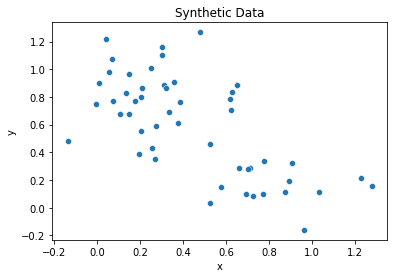

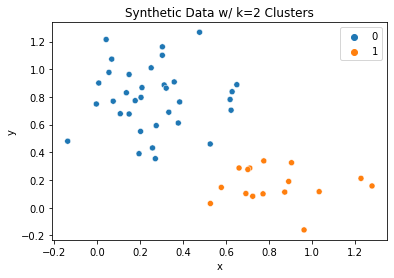

<Figure size 432x288 with 0 Axes>

In [225]:
# graphing synthetic data 
df_data = pd.read_csv("synthetic.data", sep=", ")

data_arr = df_data[["x", "y"]].to_numpy()

centroids, labels = kmeans(k=2, data=data_arr)

#first plot
sns.scatterplot(data = df_data, x = "x", y = "y").set(title="Synthetic Data")
plt.show()
plt.clf()

# second plot
sns.scatterplot(data = df_data, x = "x", y = "y", hue = labels).set(title="Synthetic Data w/ k=2 Clusters")
plt.show()
plt.clf()